In [1]:
import keras
import tensorflow as tf
import pandas as pd

# temproary 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 8]


2022-09-18 16:24:26.751126: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-18 16:24:27.115637: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-18 16:24:28.102452: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/artem/anaconda3/lib/
2022-09-18 16:24:28.102565: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: ca

In [2]:
# declare constants
TIMESTEPS_LIFT_SIDE = 6
TIMESTEPS_RIGHT_SIDE = 6

In [3]:
# prepair data
indoor_forward_6_imu = pd.read_csv(
    'data/indoor_forward_6_snapdragon_with_gt/indoor_forward_6_snapdragon_with_gt/imu.txt',
    delimiter=' ', index_col='#').set_index('timestamp').rename(
    dict(zip(
        ['ang_vel_x', 'ang_vel_y', 'ang_vel_z', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z'],
        ['avdx', 'avdy', 'avdz', 'accdx', 'accdy', 'accdz']
    )), axis=1
)
indoor_forward_6_groundtruth = pd.read_csv(
    'data/indoor_forward_6_snapdragon_with_gt/indoor_forward_6_snapdragon_with_gt/groundtruth.txt',
    delimiter=' ')\
    .rename(dict(zip(
        ['#', 'timestamp', 'tx', 'ty', 'tz', 'qx', 'qy', 'qz', 'qw'],
        ['timestamp', 'X', 'Y', 'Z', 'qx', 'qy', 'qz', 'qw', 'tmp'],
    )), axis=1)\
    .drop(['qx', 'qy', 'qz', 'qw', 'tmp'], axis=1).set_index('timestamp')
indoor_forward_9_imu = pd.read_csv(
    'data/indoor_forward_9_snapdragon_with_gt/imu.txt',
    delimiter=' ', index_col='#').set_index('timestamp').rename(
    dict(zip(
        ['ang_vel_x', 'ang_vel_y', 'ang_vel_z', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z'],
        ['avdx', 'avdy', 'avdz', 'accdx', 'accdy', 'accdz']
    )), axis=1
)
indoor_forward_9_groundtruth = pd.read_csv(
    'data/indoor_forward_9_snapdragon_with_gt/groundtruth.txt',
    delimiter=' ')\
    .rename(dict(zip(
        ['#', 'timestamp', 'tx', 'ty', 'tz', 'qx', 'qy', 'qz', 'qw'],
        ['timestamp', 'X', 'Y', 'Z', 'qx', 'qy', 'qz', 'qw', 'tmp'],
    )), axis=1)\
    .drop(['qx', 'qy', 'qz', 'qw', 'tmp'], axis=1).set_index('timestamp')

In [4]:
indoor_forward_6_imu.head()

,avdx,avdy,avdz,accdx,accdy,accdz
timestamp,,,,,,
1.540821e+09,-0.004261,-0.002131,-0.003196,0.004788,-0.225054,9.749139
1.540821e+09,-0.005326,-0.001065,-0.002131,-0.009577,-0.244207,9.749139
1.540821e+09,-0.004261,-0.000000,-0.004261,-0.004788,-0.220265,9.859272
1.540821e+09,-0.003196,-0.001065,-0.003196,0.047884,-0.215477,9.840118
1.540821e+09,-0.003196,-0.004261,-0.002131,0.057461,-0.215477,9.820965


In [5]:
indoor_forward_6_groundtruth.head()

,X,Y,Z
timestamp,,,
1.540821e+09,7.656360,0.130776,-0.911730
1.540821e+09,7.656398,0.130770,-0.911696
1.540821e+09,7.656437,0.130763,-0.911661
1.540821e+09,7.656475,0.130756,-0.911627
1.540821e+09,7.656513,0.130750,-0.911593


In [6]:
def get_speed(df, coordinate_column):
    v= list()
    for i in range(df.shape[0] - 1):
        gep = df.iloc[i:i+2][coordinate_column]
        t = gep.index[1] - gep.index[0]
        dx = gep.values[1] - gep.values[0]
        v.append(dx/t)
    v.append(None)
    return v     

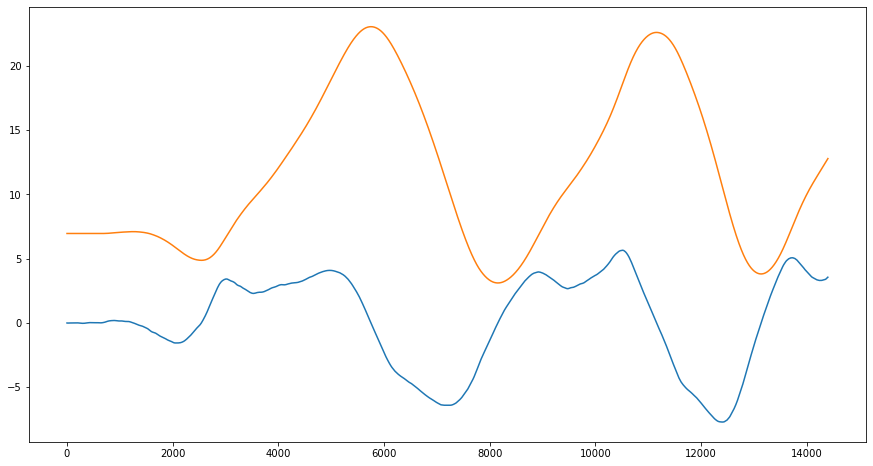

In [7]:
v = get_speed(indoor_forward_9_groundtruth, 'X')
plt.plot(v)
plt.plot(indoor_forward_9_groundtruth.X.values)

In [8]:
def add_speed(df):
    df['pVx'] = get_speed(df, 'X')
    df['pVy'] = get_speed(df, 'Y')
    df['pVz'] = get_speed(df, 'Z')

In [9]:
add_speed(indoor_forward_6_groundtruth)
add_speed(indoor_forward_9_groundtruth)

In [10]:
indoor_forward_6_groundtruth = indoor_forward_6_groundtruth.drop(['X', 'Y', 'Z'], axis=1)
indoor_forward_9_groundtruth = indoor_forward_9_groundtruth.drop(['X', 'Y', 'Z'], axis=1)

In [11]:
df = indoor_forward_6_groundtruth.join(indoor_forward_6_imu, how='outer')
index_first_pvx = df.index.get_loc(df[df.pVx.isnull() == False].index.values[0])

In [12]:
df.iloc[index_first_pvx-10:index_first_pvx+10]

,pVx,pVy,pVz,avdx,avdy,avdz,accdx,accdy,accdz
timestamp,,,,,,,,,
1.540821e+09,NaN,NaN,NaN,0.014914,-0.036219,0.001065,-0.047884,-0.330398,8.781886
1.540821e+09,NaN,NaN,NaN,-0.005326,-0.026632,-0.007457,-0.981618,-0.536298,9.289454
1.540821e+09,NaN,NaN,NaN,0.003196,-0.005326,0.018109,0.004788,-1.383841,8.690907
1.540821e+09,NaN,NaN,NaN,-0.020240,0.025566,0.001065,-0.430954,-0.761352,9.639007
1.540821e+09,NaN,NaN,NaN,-0.009587,0.035154,-0.030893,0.555452,0.090979,9.763504
1.540821e+09,NaN,NaN,NaN,-0.017044,0.026632,-0.041545,-0.148440,0.478838,10.697238
1.540821e+09,NaN,NaN,NaN,-0.017044,0.026632,-0.041545,-0.148440,0.478838,10.697238
1.540821e+09,NaN,NaN,NaN,-0.020240,-0.004261,0.006392,0.507568,0.081402,10.031653
1.540821e+09,NaN,NaN,NaN,-0.037284,-0.010653,0.015979,-0.229842,0.090979,10.826525


In [13]:
dict(zip(list(df.iloc[index_first_pvx-6:index_first_pvx+10].index.values),df.iloc[index_first_pvx-6:index_first_pvx+10].pVx))

{1540821387.4718747: nan,
 1540821387.4738767: nan,
 1540821387.475876: nan,
 1540821387.4778748: nan,
 1540821387.479876: nan,
 1540821387.4818747: nan,
 1540821387.48298: 0.019363185192553475,
 1540821387.4838767: nan,
 1540821387.48498: 0.01918401416305863,
 1540821387.485875: nan,
 1540821387.48698: 0.01901285794346775,
 1540821387.487874: nan,
 1540821387.48898: 0.018857957070456212,
 1540821387.489874: nan,
 1540821387.49098: 0.018709439191901083,
 1540821387.491874: nan}

In [14]:
def get_timestep_data(ground_trueth_time, gain_df):
    time_next_data_gain = gain_df.loc[ground_trueth_time:ground_trueth_time+0.01].index.values[0]
    index_next_time_gain = gain_df.index.get_loc(time_next_data_gain)
    first_index = index_next_time_gain - TIMESTEPS_LIFT_SIDE 
    last_index = index_next_time_gain + TIMESTEPS_RIGHT_SIDE
    timestep_data = gain_df.iloc[first_index:last_index].values
    return timestep_data

In [15]:
TIMESTEPS_LIFT_SIDE = 0
TIMESTEPS_RIGHT_SIDE = 1

In [159]:
train_data = list()
for ground_trueth_time in indoor_forward_6_groundtruth.index.values:
    train_data.append(get_timestep_data(ground_trueth_time, indoor_forward_6_imu))

train_data = np.array(train_data)
train_data = train_data[:2500].reshape(1, 2500, 6)
expected_data = indoor_forward_6_groundtruth.values[:2500].reshape(1, 2500, 3)


In [160]:
train_data.shape, expected_data.shape

((1, 2500, 6), (1, 2500, 3))

In [161]:
simplest_model.predict(train_data).shape

1/1 [==============================] - 4s 4s/step


(1, 2500, 3)

In [164]:
simplest_model = keras.Sequential([
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(16, return_sequences=True),
    keras.layers.LSTM(3, return_sequences=True),
])
simplest_model.compile(optimizer="Adam", loss="mse", metrics=["mae"])
simplest_model.fit(train_data, expected_data, epochs=50)


Epoch 1/50
1/1 [==============================] - 10s 10s/step - loss: 3.8263 - mae: 1.2243
Epoch 2/50
1/1 [==============================] - 1s 682ms/step - loss: 3.5208 - mae: 1.2084
Epoch 3/50
1/1 [==============================] - 1s 704ms/step - loss: 3.3942 - mae: 1.2612
Epoch 4/50
1/1 [==============================] - 1s 695ms/step - loss: 3.3081 - mae: 1.2606
Epoch 5/50
1/1 [==============================] - 1s 737ms/step - loss: 3.2802 - mae: 1.2441
Epoch 6/50
1/1 [==============================] - 1s 658ms/step - loss: 3.2673 - mae: 1.2458
Epoch 7/50
1/1 [==============================] - 1s 668ms/step - loss: 3.2529 - mae: 1.2612
Epoch 8/50
1/1 [==============================] - 1s 676ms/step - loss: 3.2406 - mae: 1.2657
Epoch 9/50
1/1 [==============================] - 1s 666ms/step - loss: 3.2237 - mae: 1.2620
Epoch 10/50
1/1 [==============================] - 1s 656ms/step - loss: 3.2031 - mae: 1.2563
Epoch 11/50
1/1 [==============================] - 1s 674ms/step - los

1/1 [==============================] - 0s 426ms/step


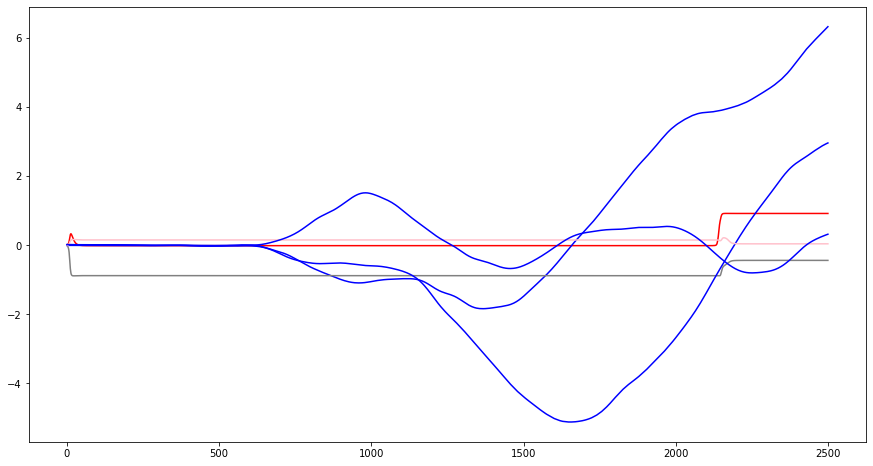

In [165]:
plt.plot(simplest_model.predict(train_data).reshape(2500, 3)[:, 0], color='red')
plt.plot(expected_data.reshape(2500, 3)[:, 0], color='blue')
plt.plot(simplest_model.predict(train_data).reshape(2500, 3)[:, 1], color='grey')
plt.plot(expected_data.reshape(2500, 3)[:, 1], color='blue')
plt.plot(simplest_model.predict(train_data).reshape(2500, 3)[:, 2], color='pink')
plt.plot(expected_data.reshape(2500, 3)[:, 2], color='blue')

In [172]:
# more complex model

train_data = list()
for ground_trueth_time in indoor_forward_6_groundtruth.index.values:
    train_data.append(get_timestep_data(ground_trueth_time, indoor_forward_6_imu))

train_data = np.array(train_data)
train_data = train_data[:5000].reshape(1, 5000, 6)
expected_data = indoor_forward_6_groundtruth.values[:5000].reshape(1, 5000, 3)


class Model2():
    def __init__(self):
        self.model = keras.Sequential([
        keras.layers.LSTM(128, return_sequences=True),
        keras.layers.LSTM(128, return_sequences=True),
        keras.layers.LSTM(128, return_sequences=True),
        keras.layers.LSTM(128, return_sequences=True),
        keras.layers.LSTM(128, return_sequences=True),
        keras.layers.LSTM(64, return_sequences=True),
        keras.layers.LSTM(32, return_sequences=True),
        keras.layers.LSTM(16, return_sequences=True),
        keras.layers.LSTM(3, return_sequences=True),
    ])
        self.optim = keras.optimizers.Adam(lr=0.0001)
        self.loss = tf.keras.losses.MeanSquaredError()
    
    @tf.function
    def train_step(self, input_data, expected_data):
        with tf.GradientTape() as tape:
            predicet_data = self.model(input_data, training=True)
            loss = self.loss(expected_data, predicet_data)
        
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optim.apply_gradients(zip(gradients, self.model.trainable_variables))
        return loss
    

        
    def fit(self, input_data, expected_data, epoch_number):
        for ep in range(1, epoch_number+1):
            for i in range(0, input_data.shape[1]-500, 500):
                self.train_step(input_data[:,i:i+500], expected_data[:,i:i+500])
            loss = self.train_step(input_data, expected_data)
            print(f'ep {ep}, loss {loss}')

model2 = Model2()
model2.fit(train_data, expected_data, 30)
            

/home/artem/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


ep 1, loss 13.402771949768066
ep 2, loss 13.402398109436035
ep 3, loss 13.402121543884277
ep 4, loss 13.40250015258789
ep 5, loss 13.402801513671875
ep 6, loss 13.402729988098145
ep 7, loss 13.401626586914062
ep 8, loss 13.397834777832031
ep 9, loss 13.384698867797852
ep 10, loss 13.366279602050781
ep 11, loss 13.346598625183105
ep 12, loss 13.342996597290039
ep 13, loss 13.418740272521973
ep 14, loss 13.366766929626465
ep 15, loss 13.298913955688477
ep 16, loss 13.304973602294922
ep 17, loss 13.291131019592285
ep 18, loss 13.39189338684082
ep 19, loss 13.325675010681152
ep 20, loss 13.280227661132812
ep 21, loss 13.261309623718262
ep 22, loss 13.230262756347656
ep 23, loss 13.231252670288086
ep 24, loss 13.149873733520508
ep 25, loss 13.191706657409668
ep 26, loss 13.099244117736816
ep 27, loss 13.070331573486328
ep 28, loss 13.001813888549805
ep 29, loss 13.005257606506348
ep 30, loss 13.09277629852295


1/1 [==============================] - 1s 846ms/step


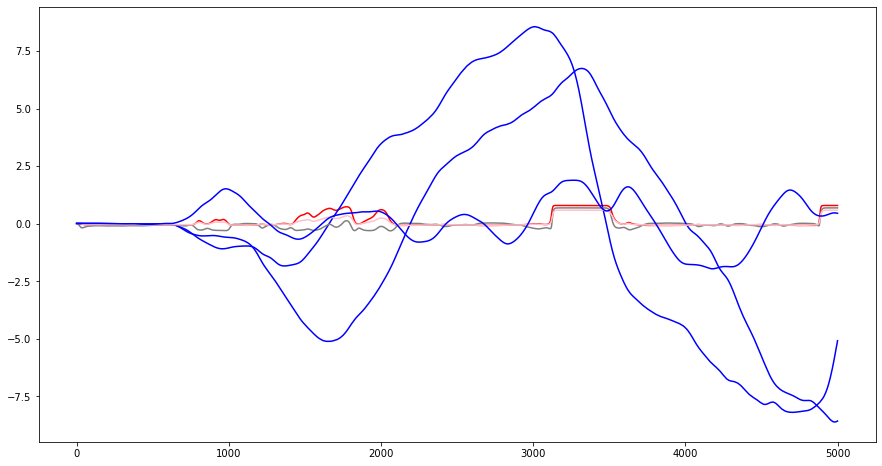

In [174]:
plt.plot(model2.model.predict(train_data).reshape(5000, 3)[:, 0], color='red')
plt.plot(expected_data.reshape(5000, 3)[:, 0], color='blue')
plt.plot(model2.model.predict(train_data).reshape(5000, 3)[:, 1], color='grey')
plt.plot(expected_data.reshape(5000, 3)[:, 1], color='blue')
plt.plot(model2.model.predict(train_data).reshape(5000, 3)[:, 2], color='pink')
plt.plot(expected_data.reshape(5000, 3)[:, 2], color='blue')